In [16]:
#sempre lembrar de limpar a pasta tmp ao final do exercício

# import shutil
# shutil.rmtree('/tmp_img')
# shutil.rmtree('/tmp_csv')
# shutil.rmtree('/tmp_img_resized')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import cv2
import glob
import os
import re
from google.colab import drive
from functools import lru_cache
import requests

In [2]:
RESCALE_RATIO = 35
states = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO', 'DF']

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
def open_image_internet(url):
  return cv2.imdecode(np.asarray(bytearray(requests.get(url).content)), -1)

def open_image(path):
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  return img

def BGR2RGB(img):
  return img[:,:,::-1]
  
def crop_image(img_orig):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
  gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces):
    (x,y,w,h) = faces[0]
    img_cropped = img_orig[
        max(0,y-30):
        min(img_orig.shape[0]-1,y+h+30), 
        max(0, x-30):
        min(img_orig.shape[1]-1,x+w+30),
        :]
    return img_cropped
  else:
    square = min(img_orig.shape[0], img_orig.shape[1])//2
    mid_height = img_orig.shape[0]//2
    mid_width = img_orig.shape[1]//2
    return img_orig[mid_height-square:mid_height+square,mid_width-square:mid_width+square]

def unzip_files(input_folder, file, output_folder):
  from_path = f'{input_folder}/{file}'
  zip_ref = zipfile.ZipFile(from_path, 'r')
  zip_ref.extractall(output_folder)
  zip_ref.close()

@lru_cache(maxsize=None)
def get_img_filenames(state):
  os.chdir('/tmp_img')
  img_lists = [glob.glob(e) for e in ('*'+state+'*.jpg', '*'+state+'*.png', '*'+state+'*.jpeg')]
  img_list = [item for sublist in img_lists for item in sublist]
  return set(img_list)

def get_img_filename_from_sq_candidato(state, sq_candidato):
  filenames = get_img_filenames(state)
  option1, option2 = 'F'+state+str(sq_candidato)+'_div.jpg', 'F'+state+str(sq_candidato)+'_div.jpeg'
  if option1 in filenames:
    return option1
  elif option2 in filenames:
    return option2
  else:
    return ''

def get_candidates_from_state(state):
  os.chdir('/tmp_csv')
  data_filename = glob.glob('*'+state+'.csv')
  data_df = pd.read_csv(r'/tmp_csv/'+data_filename[0], encoding='iso-8859-1', on_bad_lines='warn', sep=';')
  data_df['filename'] = data_df['SQ_CANDIDATO'].map(lambda sq_candidato: get_img_filename_from_sq_candidato(state, sq_candidato))
  return data_df[['NM_CANDIDATO', 'DS_CARGO', 'SQ_CANDIDATO', 'DS_SIT_TOT_TURNO', 'CD_SIT_TOT_TURNO', 'filename']].query('filename != ""') 

def get_candidates():
  return pd.concat([get_candidates_from_state(state) for state in states])

def get_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "ELEITO" or DS_SIT_TOT_TURNO == "ELEITO POR MÉDIA"') 

def get_not_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "NÃO ELEITO"')

def get_faces(elected_df):
  return np.array([open_image('/tmp_img/'+filename) for filename in elected_df['filename'].values])

def get_cropped_faces(faces):
  return np.array([crop_image(face) for face in faces])

def get_resized_faces_aux(cropped_faces, x_max, y_max):
  return np.array([cv2.resize(cropped_face, (x_max, y_max), interpolation = cv2.INTER_AREA) for cropped_face in cropped_faces])

def get_resized_faces(cropped_faces):
  y_max = np.max([cropped_face.shape[0] for cropped_face in cropped_faces])
  x_max = np.max([cropped_face.shape[1] for cropped_face in cropped_faces])
  return get_resized_faces_aux(cropped_faces, x_max, y_max)
  
def get_flatten_faces(faces):
  return faces.reshape((faces.shape[0], np.prod(faces.shape[1:])))

def output_imgs(folder, candidates_df, resized_imgs):
  if not os.path.exists(folder):
    os.makedirs(folder)
  os.chdir(folder)

  for idx_row in range(candidates_df.shape[0]):
    filename = candidates_df.iloc[idx_row]['filename']
    if filename != '':
      cv2.imwrite(filename, resized_imgs[idx_row])
    else:
      continue

Unzip Files

In [5]:
unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'consulta_cand_2022.zip', '/tmp_csv')
for state in states:
  unzip_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022/2022', 'foto_cand2022_'+state+'_div.zip', '/tmp_img')

Save Resized Images (Only Play Me Once)

In [6]:
candidates_df = get_candidates()
candidates_faces = get_faces(candidates_df)
candidates_faces = get_cropped_faces(candidates_faces)
candidates_faces = get_resized_faces(candidates_faces)
output_imgs('/tmp_img_resized',  candidates_df, candidates_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Play for Real

In [7]:
from google.colab import files
!zip -r /content/img_resized.zip /tmp_img_resized
files.download("/content/img_resized.zip")

A saída de streaming foi truncada nas últimas 5000 linhas.
  adding: tmp_img_resized/FRS210001596928_div.jpg (deflated 2%)
  adding: tmp_img_resized/FSP250001597683_div.jpg (deflated 3%)
  adding: tmp_img_resized/FPI180001738237_div.jpeg (deflated 2%)
  adding: tmp_img_resized/FSE260001602600_div.jpeg (deflated 2%)
  adding: tmp_img_resized/FGO90001651109_div.jpg (deflated 2%)
  adding: tmp_img_resized/FPE170001730684_div.jpeg (deflated 2%)
  adding: tmp_img_resized/FSC240001645244_div.jpg (deflated 3%)
  adding: tmp_img_resized/FBA50001604577_div.jpg (deflated 1%)
  adding: tmp_img_resized/FRO220001635665_div.jpg (deflated 2%)
  adding: tmp_img_resized/FTO270001676109_div.jpg (deflated 2%)
  adding: tmp_img_resized/FSP250001721343_div.jpeg (deflated 3%)
  adding: tmp_img_resized/FPB150001613756_div.jpg (deflated 2%)
  adding: tmp_img_resized/FES80001651641_div.jpeg (deflated 2%)
  adding: tmp_img_resized/FRJ190001615320_div.jpg (deflated 2%)
  adding: tmp_img_resized/FRJ190001638462_d

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
elected_df = get_elected(get_candidates())
elected_faces = get_faces(elected_df)
cropped_elected_faces = get_cropped_faces(elected_faces)
resized_cropped_ellected_faces = get_resized_faces(cropped_elected_faces)
elected_flattened_faces = get_flatten_faces(resized_cropped_ellected_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Faces: variável com os rostos dos candidatos eleitos

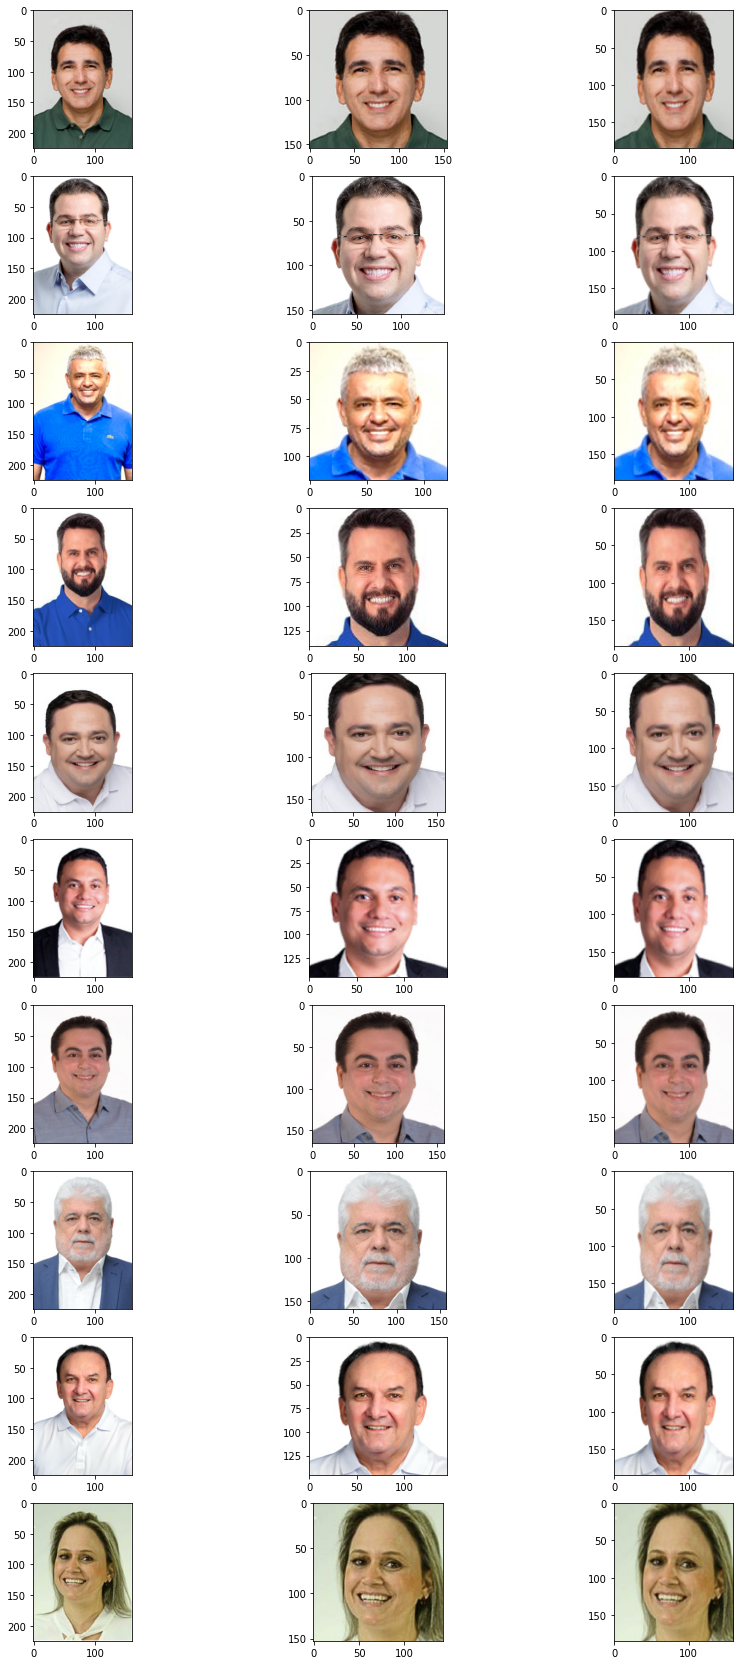

In [9]:
n_rows = 10
n_cols = 3

lines = np.random.choice(elected_faces.shape[0], n_rows, replace=False)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,30))
for idx, (img_orig, img_cropp, img_resized) in enumerate(zip(elected_faces[lines], cropped_elected_faces[lines], resized_cropped_ellected_faces[lines])):
  axs[idx][0].imshow(BGR2RGB(img_orig));
  axs[idx][1].imshow(BGR2RGB(img_cropp));
  axs[idx][2].imshow(BGR2RGB(img_resized));

PCA

Fonte: https://github.com/lewagon/data-challenges/blob/master/05-ML/06-Unsupervised-Learning/02-Face-Recognition/face_recognition.ipynb

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

Construir o PCA dos candidatos eleitos com 10 componentes

In [11]:
elected_flattened_faces = MinMaxScaler().fit_transform(elected_flattened_faces)
pca = PCA(n_components=50, svd_solver='full').fit(elected_flattened_faces)
data_projected = pca.transform(elected_flattened_faces)

Play

Avaliar os metadados do PCA

In [12]:
pca.components_.shape

(50, 88800)

Reconstrução dos rostos dos candidatos a partir da operação inversa da transformação do PCA

In [13]:
data_reconstructed = pca.inverse_transform(data_projected)

Imagem Original vs. Reconstrução de uma Imagem 

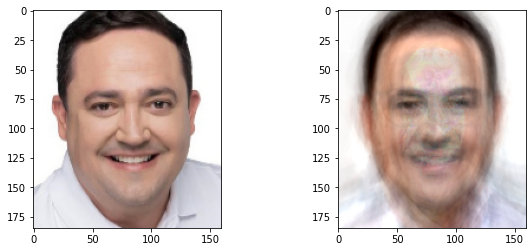

In [14]:
ith = lines[np.random.randint(lines.shape[0])]
elected_person_image = resized_cropped_ellected_faces[ith]
elected_person_reconstructed_image = data_reconstructed[ith].reshape(resized_cropped_ellected_faces[ith].shape)
fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(BGR2RGB(elected_person_image));
axs[1].imshow(BGR2RGB(elected_person_reconstructed_image));

Imagens Reconstruídas

Reconstrução da imagem padrão de candidatos eleitos a partir do componente principal

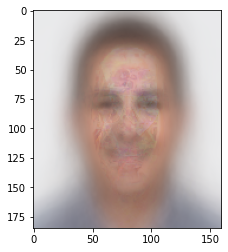

In [15]:
plt.imshow(BGR2RGB(pca.mean_.reshape(elected_person_reconstructed_image.shape)));

Busca pelo número ideal de componentes principais

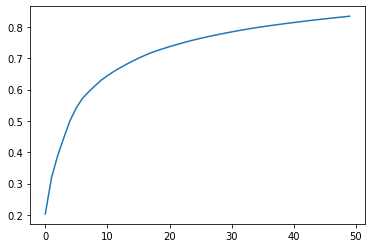

In [16]:
import seaborn as sns
sns.lineplot(x=np.arange(pca.explained_variance_ratio_.shape[0]), y=pca.explained_variance_ratio_.cumsum())

Reconstrução da imagem padrão de candidatos eleitos a partir das componentes principais

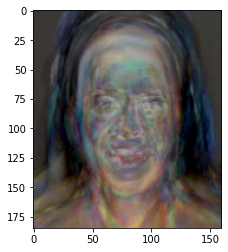

In [17]:
n_components = 1

sc = MinMaxScaler()
sc = sc.fit(pca.components_)
input_transformado = sc.transform(pca.components_[0:n_components])
input_transformado = np.expand_dims(input_transformado.mean(axis=0), axis=1)
input_transformado = input_transformado.reshape(elected_person_reconstructed_image.shape)
plt.imshow(BGR2RGB(input_transformado));

Autoencoder

Fonte: https://github.com/heliomacedofilho/data-challenges/blob/master/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/autoencoders.ipynb

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import seaborn as sns

In [19]:
latent_dimension = 5

In [20]:
candidates_df = get_candidates()

In [21]:
elected_df = get_elected(candidates_df)[['filename']].copy()
elected_df['y'] = 1

In [22]:
not_elected_df = get_not_elected(candidates_df)[['filename']]
not_elected_indices = np.random.choice(not_elected_df.shape[0], elected_df.shape[0], replace=False)
not_elected_df = not_elected_df.iloc[not_elected_indices].copy()
not_elected_df['y'] = 0

In [23]:
#candidates_df = pd.concat([elected_df, not_elected_df], axis=0).sample(frac=1)

In [24]:
candidates_df = elected_df

In [25]:
X = get_resized_faces(get_cropped_faces(get_faces(candidates_df.drop(columns='y'))))/255
y = candidates_df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [26]:
#Fazer resize para largura e altura serem múltiplos de 4
h_div_4, w_div_4 = np.array(X.shape[1:3])//4
X = get_resized_faces_aux(X, w_div_4*4, h_div_4*4)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Encoder

In [28]:
def build_encoder(latent_dimension):
    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Conv2D(8, (2,2), input_shape=X_train.shape[1:], activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(16, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))

    encoder.add(Conv2D(32, (2, 2), activation='relu'))
    encoder.add(MaxPooling2D(2))     

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [29]:
encoder_model = build_encoder(latent_dimension)
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 183, 159, 8)       104       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 91, 79, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 78, 16)        528       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 39, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 38, 32)        2080      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 22, 19, 32)       0

Decoder

In [30]:
def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(h_div_4*w_div_4*8, input_shape=(latent_dimension, ), activation='tanh'))
    decoder.add(Reshape((h_div_4,w_div_4,8)))
    decoder.add(Conv2DTranspose(8, kernel_size=(2,2), strides=(2, 2), padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, kernel_size=(2,2), strides=(2, 2), padding='same', activation='relu'))

    return decoder

In [31]:
decoder_model = build_decoder(latent_dimension)
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 14720)             88320     
                                                                 
 reshape (Reshape)           (None, 46, 40, 8)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 92, 80, 8)        264       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 184, 160, 3)      99        
 ranspose)                                                       
                                                                 
Total params: 88,683
Trainable params: 88,683
Non-trainable params: 0
_________________________________________________________________


Autoencoder

In [32]:
def build_autoencoder(encoder, decoder):
    inp = Input(X.shape[1:])
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

In [33]:
model = build_autoencoder(encoder_model, decoder_model)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 184, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 5)                 69597     
                                                                 
 sequential_1 (Sequential)   (None, 184, 160, 3)       88683     
                                                                 
Total params: 158,280
Trainable params: 158,280
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(loss='mse', optimizer='adam', metrics='mse')

In [35]:
es = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, X_train, batch_size=32, epochs=50, callbacks=es, validation_split=0.3)

Epoch 1/50
9/9 [==============================] - 4s 379ms/step - loss: 0.5352 - mse: 0.5352 - val_loss: 0.5205 - val_mse: 0.5205
Epoch 2/50
9/9 [==============================] - 3s 328ms/step - loss: 0.5144 - mse: 0.5144 - val_loss: 0.4970 - val_mse: 0.4970
Epoch 3/50
9/9 [==============================] - 3s 376ms/step - loss: 0.4886 - mse: 0.4886 - val_loss: 0.4683 - val_mse: 0.4683
Epoch 4/50
9/9 [==============================] - 4s 471ms/step - loss: 0.4568 - mse: 0.4568 - val_loss: 0.4326 - val_mse: 0.4326
Epoch 5/50
9/9 [==============================] - 3s 337ms/step - loss: 0.4175 - mse: 0.4175 - val_loss: 0.3881 - val_mse: 0.3881
Epoch 6/50
9/9 [==============================] - 4s 463ms/step - loss: 0.3689 - mse: 0.3689 - val_loss: 0.3350 - val_mse: 0.3350
Epoch 7/50
9/9 [==============================] - 3s 353ms/step - loss: 0.3117 - mse: 0.3117 - val_loss: 0.2756 - val_mse: 0.2756
Epoch 8/50
9/9 [==============================] - 3s 336ms/step - loss: 0.2510 - mse: 0.25

Play

In [36]:
X_encoded = model.layers[1]
X_decoded = model.layers[2]

In [37]:
compressed_X_train = X_encoded.predict(X_train)

12/12 [==============================] - 1s 98ms/step


Visualizing candidates in latent space

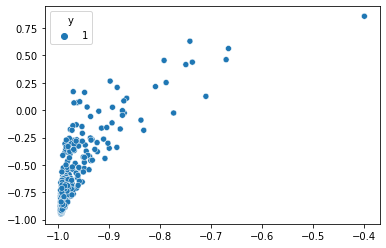

In [38]:
sns.scatterplot(x=compressed_X_train[:,0], y=compressed_X_train[:,1], hue=y_train, cmap='Dark2');

Imagem Original vs. Construção de uma Imagem

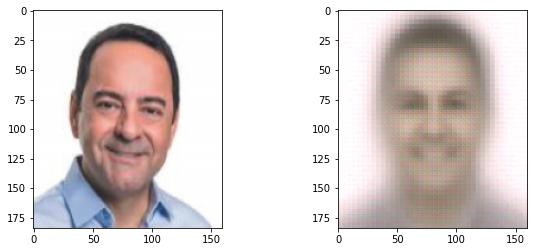

In [47]:
decompressed_X_train = X_decoded(compressed_X_train)

ith = np.random.randint(X_train.shape[0])
elected_person_image = X_train[ith]
elected_person_reconstructed_image = np.squeeze(decompressed_X_train[ith])

fig, axs = plt.subplots(1, 2, figsize=(10,4))
axs[0].imshow(BGR2RGB(elected_person_image));
axs[1].imshow(BGR2RGB(elected_person_reconstructed_image));

Teste Autoencoder

In [44]:
def reconstituir_foto(candidate_photo):
  compressed_X_train = X_encoded.predict(np.expand_dims(candidate_photo, axis=0))
  decompressed_X_train = X_decoded(compressed_X_train)

  candidate_reconstructed_image = np.squeeze(decompressed_X_train[0])

  fig, axs = plt.subplots(1, 2, figsize=(10,4))
  axs[0].imshow(BGR2RGB(candidate_photo));
  axs[1].imshow(BGR2RGB(candidate_reconstructed_image));

In [48]:
url_foto_lula = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/893498/foto.jpg'
url_foto_bolsonaro = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/908966/foto.jpeg'
foto_lula = open_image_internet(url_foto_lula)
foto_bolsonaro = open_image_internet(url_foto_bolsonaro)
foto_lula, foto_bolsonaro = get_resized_faces_aux(get_cropped_faces([foto_lula, foto_bolsonaro]), w_div_4*4, h_div_4*4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/1 [==============================] - 0s 52ms/step


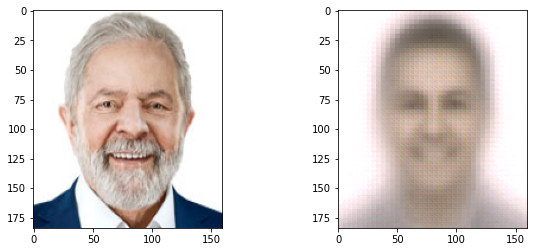

In [45]:
reconstituir_foto(foto_lula)

1/1 [==============================] - 0s 100ms/step


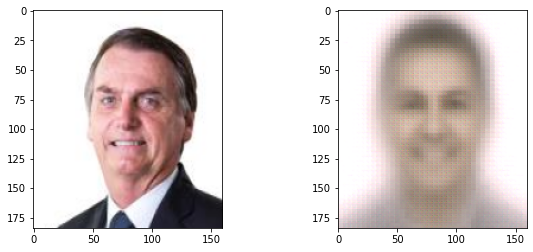

In [46]:
reconstituir_foto(foto_bolsonaro)